### **Spatial Correlation and Fourier Analysis**

#### **1. Fundamentals of Spatial Correlation and Its Computation:**
Spatial correlation provides a quantitative measure of the relationship between points in a dataset across space. Such relationships are pivotal in disciplines like imaging or fluid dynamics, where patterns in pixel values or velocities across varied positions hold significance.

The spatial correlation function, denoted by $C(r)$, elucidates this relationship based on the distance or lag between data points. Mathematically, this is represented as:
$$
C(r) = \langle f(\mathbf{x}) f(\mathbf{x} + \mathbf{r}) \rangle,
$$
where:
- $f(\mathbf{x})$ symbolizes the value of the function, such as pixel intensity or velocity, at position $\mathbf{x}$.
- The angle brackets indicate an ensemble average over all conceivable positions $\mathbf{x}$.

From the field of velocities, the mean speed is deduced as:
$$
\left\langle \left| \mathbf{v}(r,t) \right| \right\rangle_{r,t} = \frac{1}{T} \sum_{t} \left| \mathbf{v}(r,t) \right|,
$$
where $T$ embodies the total number of evaluated frames. Concurrently, for each frame, represented by $t$, the velocity autocorrelation, $A_{\text{vel}}(r,t)$, is computed:
$$
A_{\text{vel}}(r,t) = \frac{\langle v(r,t) \cdot v(r',t) \rangle}{\langle v(r,t) \rangle \cdot \langle v(r',t) \rangle} = \frac{2}{N(N-1)} \sum_{j} \sum_{i<j} v(r_i,t) \cdot v(r_j,t).
$$

#### **2. Fourier Transforms and Their Relevance:**
Fourier transforms offer an analytical tool to transition from time or spatial domains to their frequency components. Within spatial correlations, this technique facilitates the identification of patterns or properties that might otherwise remain concealed in the spatial representation.

The 2D Fourier transform, aptly suited for two-dimensional datasets, is articulated as:
$$
F(\mathbf{k}) = \int f(\mathbf{x}) e^{-i\mathbf{k}\cdot\mathbf{x}} d\mathbf{x}.
$$
Herein:
- $F(\mathbf{k})$ is the transformed version of $f(\mathbf{x})$.
- $\mathbf{k}$ signifies the wave vector in the frequency domain.

The correlation function, $A_{\text{vel}}(r,t)$, is then efficiently transformed to the Fourier space to minimize computational demands.

#### **3. Wiener-Khinchin Theorem and Determining the Correlation Length:**
The Wiener-Khinchin theorem posits a relationship between a signal's autocorrelation function and its power spectrum, stating that the Fourier transform of the former equates to the latter. Symbolically:
$$
C(r) \xrightarrow{FT} |F(k)|^2.
$$

To apply this theorem to 2D datasets, the following steps are undertaken:
1. The dataset undergoes a 2D Fourier transform.
2. The resultant magnitude is squared to yield the power spectrum.
3. This spectrum is reverted to the spatial domain using an inverse 2D Fourier transform.

From the spatial correlation function, a correlation length is discerned, representing the extent over which two points retain significant correlation. This length is derived from the velocity autocorrelation, $A_{\text{vel}}(r,\tau)$, fitted to an exponential decay model:
$$
A_{\text{vel}}(r,\tau) = Ae^{-\frac{\tau}{B}} + C.
$$
The correlation length, symbolized by $\lambda(\tau)$, is then given by:
$$
\lambda(\tau) = -B \times \log \left( \frac{0.3-C}{A} \right).
$$
Temporal averages of this length, represented by $\langle \lambda(\tau) \rangle$, furnish an overarching correlation length for the entire experimental dataset.


In [14]:
import os
import glob
import sys
sys.path.append('../../activedrops')

import autocorrelation
import pivdrops
import viz
viz.set_plotting_style()

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


Ok, so first let's read the data. We'll generate a function that reads txt files from a folder and gives us the coordinates and velocity components in microns.

In [19]:
input_dir = "../../data/k401bio-250nM-piv/"
input_pattern = os.path.join(input_dir, 'PIVlab_*.txt')
file_paths = sorted(glob.glob(input_pattern))

In [20]:
def load_and_convert_data(file_path):
    """
    Load data from a specified file path and convert units.
    
    Parameters:
    - file_path (str): Path to the data file.
    
    Returns:
    - DataFrame: Processed data with columns 'x [um]', 'y [um]', 'u [um/s]', and 'v [um/s]'.
    """
    
    # Load the data
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity units
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Replace NaN values with 0s
    df = df.fillna(0)
    
    # Retain only the converted columns
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df

    # Load and convert data
df = load_and_convert_data(file_paths[500])
df

,x [um],y [um],u [um/s],v [um/s]
0,23.287672,23.287672,0.0,0.0
1,23.287672,45.205481,0.0,0.0
2,23.287672,67.123285,0.0,0.0
3,23.287672,89.041096,0.0,0.0
4,23.287672,110.958907,0.0,0.0
...,...,...,...,...
16124,2784.931567,2697.260352,0.0,0.0
16125,2784.931567,2719.178097,0.0,0.0
16126,2784.931567,2741.095843,0.0,0.0
16127,2784.931567,2763.013588,0.0,0.0


Now let's proceed with our fourier analysis. Why do we need fourier at all? Because fourier space deals with waves and frquencies, and operations are computationally much simpler. 

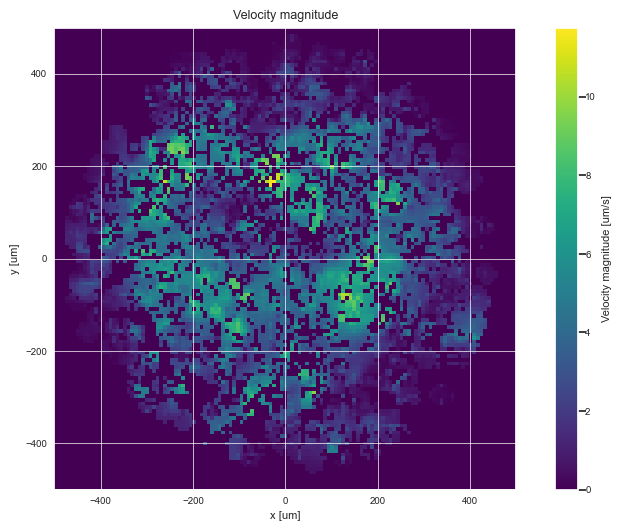

In [21]:
# # Take falues from u and v components and turn them into numpy arrays
u = df.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
v = df.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

# reshape_dim = int(np.sqrt(df.shape[0]))
# u, v = df['u [um/s]'].values.reshape((reshape_dim, reshape_dim)), df['v [um/s]'].values.reshape((reshape_dim, reshape_dim))
# Calculate the magnitude of the velocity
magnitude = np.sqrt(u**2 + v**2)

# Plot the magnitude of the velocity
plt.figure(figsize=(10, 6))  # Set the figure size
im = plt.imshow(magnitude, cmap='viridis', origin='lower', extent=[-500, 500, -500, 500])
plt.xlabel('x [um]')
plt.ylabel('y [um]')
cbar = plt.colorbar(im)
cbar.set_label('Velocity magnitude [um/s]')
plt.title('Velocity magnitude')
plt.show()



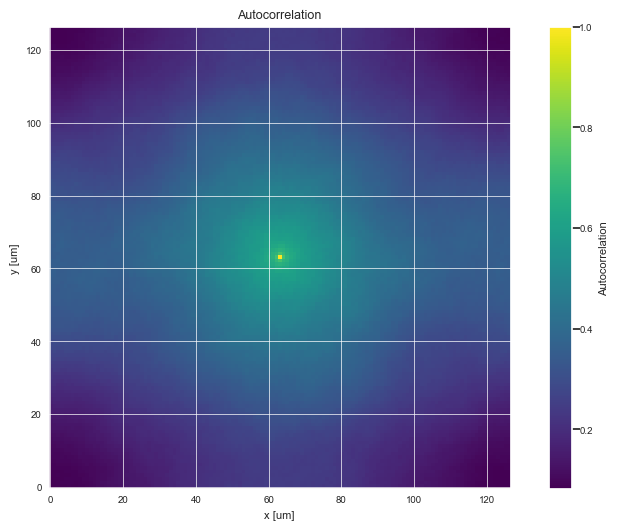

In [23]:
# Calculate the autocorrelation function with fourier transform
full_product = np.fft.fft2(magnitude) * np.conj(np.fft.fft2(magnitude))

# get the real part of the inverse fourier transform (autocorrlation function)
inverse = np.real(np.fft.ifft2(full_product))

# normalize the autocorrelation function
normalized_inverse = inverse / inverse[0, 0]

# shift the autocorrelation function so that the center is at the center of the image
shifted_inverse =  np.fft.fftshift(normalized_inverse)

# plot inverse fourier transform of the product of the fourier transform of the magnitude of the velocity
plt.figure(figsize=(10, 6))  # Set the figure size
im = plt.imshow(shifted_inverse, cmap='viridis', origin='lower')
plt.xlabel('x [um]')
plt.ylabel('y [um]')
cbar = plt.colorbar(im)
cbar.set_label('Autocorrelation')
plt.title('Autocorrelation')
plt.show()


How do we compute the spatial autocorrelation with a space lag $r$?

Imagine you have a large checkerboard. Some squares have stickers on them, and some don't. Now, you want to know if the stickers are placed randomly, or if there's a pattern. If you find a sticker in one spot, is there likely to be another sticker a certain number of spaces away?

**Spatial autocorrelation** is like a magic magnifying glass that helps you see these patterns. When you look through this magnifying glass at a specific number of spaces (let's say 3 spaces), it shows you a number. If the number is close to 1, it means when you find a sticker, there's a high chance you'll find another sticker 3 spaces away. If the number is close to -1, it means you're unlikely to find another sticker 3 spaces away. If the number is around 0, it means there's no special pattern; it's just random.

Now, the formula:

$$
\frac{\text{{inverse}}[r, r] + \text{{inverse}}[-r, -r]}{\text{{shape}}[0] \times \text{{shape}}[1]}
$$

is like a special rule for using the magic magnifying glass. Here's how it works:

1. **inverse[r, r]**: This is like looking 3 spaces to the right and 3 spaces down to see if there's another sticker.
2. **inverse[-r, -r]**: This is like looking 3 spaces to the left and 3 spaces up. It's the opposite direction of the first look.
3. Adding these two looks together gives an average idea of the pattern in both directions.
4. Dividing by the size of the checkerboard (**shape[0] x shape[1]**) ensures that our magic number isn't too big or too small. It's like adjusting the magnifying glass to fit the size of our board.


Notice how at r=0 we have the maximum autocorrelation. This is because the autocorrelation function is the convolution of the image with itself. At r=0, the image is being convolved with itself at the same location, so the correlation is perfect.

In [ ]:
n = 50
results = np.zeros(n)

for r in list(range(0, n)):
    autocorrelation = (inverse[r, r] + inverse[-r, -r]) / (magnitude.shape[0] * magnitude.shape[1])
    results[r] = autocorrelation

results = results / results[0]
results

In [ ]:
# plot the autocorrelation function 
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(results)
plt.xlabel('r [microns]')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation')
plt.show()

Cool! Now we're set to compute the correlation length. We need to fit our data to an exponential function and extract the term dividing our values.

In [ ]:
# Define the exponential decay function
def exponential_decay(tau, A, B, C):
    return A * np.exp(-tau/B) + C

# Fit the data to the exponential decay
params, covariance = curve_fit(exponential_decay, np.arange(len(results)), results, maxfev=5000)

A, B, C = params

# Calculate the correlation length
lambda_tau = -B * np.log((0.3 - C) / A) 
lambda_tau

There's some doubt about the scale of r. Microns or just units of distance between measured pixels/kernels (27x27)? Let's assume everything is in microns.

Now let's proceed to condense all our work in two functions: one for processing raw PIV data and automate our analysis, and other for plotting.

In [ ]:
import os
import glob
import sys
sys.path.append('../../activedrops')

import autocorrelation
import pivdrops
import viz
viz.set_plotting_style()

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def autocorrelation(file_path, r_values):
    """
    Load data from a specified file path and convert units.
    
    Parameters:
    - file_path (str): Path to the data file.
    
    Returns:
    - DataFrame: Processed data with columns 'x [um]', 'y [um]', 'u [um/s]', and 'v [um/s]'.
    """
    
    # Load the data
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity units
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Replace NaN values with 0s
    df = df.fillna(0)
    
    # Retain only the converted columns
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]

    # # Take values from u and v components and turn them into numpy arrays
    u = df.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = df.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Calculate the magnitude of the velocity
    magnitude = np.sqrt(u**2 + v**2)

    # Calculate the autocorrelation function with Fourier transform
    full_product = np.fft.fft2(magnitude) * np.conj(np.fft.fft2(magnitude))

    # get the real part of the inverse Fourier transform (autocorrelation function)
    inverse = np.real(np.fft.ifft2(full_product))

    results = np.zeros(r_values)

    for r in list(range(0, r_values)):
        autocorrelation = (inverse[r, r] + inverse[-r, -r]) / (magnitude.shape[0] * magnitude.shape[1])
        results[r] = autocorrelation

    results = results / results[0]

    # Define the exponential decay function
    def exponential_decay(tau, A, B, C):
        return A * np.exp(-tau/B) + C

    # Fit the data to the exponential decay
    params, covariance = curve_fit(exponential_decay, np.arange(len(results)), results, maxfev=5000)

    A, B, C = params

    # This should fix the issue
    fitted_values = exponential_decay(np.arange(r_values), A, B, C)

    # Calculate the correlation length
    lambda_tau = -B * np.log((0.3 - C) / A) 
    
    return lambda_tau, inverse, results, fitted_values



In [ ]:
def plot_autocorrelation_values(lambda_tau, results, fitted_values, filename=None):
    """
    Plots the autocorrelation values and the fitted exponential decay.
    
    Parameters:
    - lambda_tau (float): Correlation length.
    - results (array): Array of autocorrelation values.
    - fitted_values (array): Array of fitted values.
    - filename (str, optional): If provided, the plot will be saved to this filename.
    
    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))
    
    # Plot autocorrelation values and fitted exponential decay
    plt.plot(results, label='Autocorrelation Values', marker='o', linestyle='-', markersize=5)
    plt.plot(fitted_values, label='Fitted Exponential Decay', linestyle='--', color='red')
    plt.axvline(x=lambda_tau, color='green', linestyle='-.', label=f'Correlation Length = {lambda_tau:.2f}')
    
    # Adding labels, title, and legend
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function and Fitted Exponential Decay')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    
    # If filename is provided, save the plot
    if filename:
        directory = os.path.dirname(filename)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(filename, dpi=200, format='jpg')
    else:
        plt.show()

input_dir = "../../data/k401bio-250nM-piv/"
input_pattern = os.path.join(input_dir, 'PIVlab_*.txt')
file_paths = sorted(glob.glob(input_pattern))

# r values from 0 to 50
r_values = 50
# Now, let's run the fixed function
cl, inverse, results, fitted_values = autocorrelation(file_paths[2000], r_values)

# Test the function by displaying the plot
plot_autocorrelation_values(cl, results, fitted_values)


In [ ]:
def combined_plot(lambda_tau, inverse, results, fitted_values, filename=None):
    """
    Creates a side-by-side plot of autocorrelation values and the fitted exponential decay.
    
    Parameters:
    - lambda_tau (float): Correlation length.
    - inverse (array): 2D array from the inverse Fourier transform.
    - results (array): Array of autocorrelation values.
    - fitted_values (array): Array of fitted values.
    - filename (str, optional): If provided, the plot will be saved to this filename.
    
    Returns:
    - None
    """
    # Create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # First plot: Autocorrelation plot of the inverse Fourier transform
    normalized_inverse = inverse / inverse[0, 0]
    shifted_inverse = np.fft.fftshift(normalized_inverse)
    im = axs[0].imshow(shifted_inverse, cmap='viridis', origin='lower')
    axs[0].set_xlabel('x [um]')
    axs[0].set_ylabel('y [um]')
    cbar = fig.colorbar(im, ax=axs[0])
    cbar.set_label('Autocorrelation')
    axs[0].set_title('Autocorrelation')
    
    # Second plot: Autocorrelation values and fitted exponential decay
    axs[1].plot(results, label='Autocorrelation Values', marker='o', linestyle='-', markersize=5)
    axs[1].plot(fitted_values, label='Fitted Exponential Decay', linestyle='--', color='red')
    axs[1].axvline(x=lambda_tau, color='green', linestyle='-.', label=f'Correlation Length = {lambda_tau:.2f}')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Autocorrelation')
    axs[1].set_title('Autocorrelation Function and Fitted Exponential Decay')
    axs[1].legend()
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    
    # If filename is provided, save the plot
    if filename:
        directory = os.path.dirname(filename)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(filename, dpi=200, format='jpg')
    else:
        plt.show()




# Test the function by displaying the plots
combined_plot(cl, inverse, results, fitted_values)

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def plot_with_slider(frame=0):
    """
    Plots the autocorrelation values and fitted exponential decay based on the selected frame.
    
    Parameters:
    - frame (int): Frame number. 
    
    Returns:
    - None
    """
    # Calculate autocorrelation for the selected frame
    cl, inverse, results, fitted_values = autocorrelation(file_paths[frame], r_values)
    
    # Display the plots
    combined_plot(cl, inverse, results, fitted_values)

# Create an interactive widget
interactive_plot = widgets.interactive(plot_with_slider, 
                                       frame=widgets.IntSlider(min=0, max=len(file_paths)-1, step=1, value=0))

# Display the interactive widget
display(interactive_plot)


Now multiple frames

In [12]:
import os
import glob
import sys
sys.path.append('../../activedrops')

import autocorrelation
import pivdrops
import viz
viz.set_plotting_style()

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt

def autocorrelation_movie(file_paths, r_values=50, output_dir=None):
    """
    Processes a list of file paths and extracts various autocorrelation metrics.
    
    Parameters:
    - file_paths (list of str): List of paths to data files.
    - r_values (int, optional): Number of r values for the autocorrelation. Default is 50.
    - output_dir (str, optional): Directory path to save the resulting DataFrame. If not provided, data won't be saved.
    
    Returns:
    - DataFrame: Contains columns:
        - 'file_name': Name of the processed file
        - 'time [min]': Computed time in minutes
        - 'Correlation Length': Extracted correlation length
        - 'inverse': Inverse Fourier transform of the magnitude
        - 'results': Autocorrelation results
        - 'fitted_values': Values fitted to the exponential decay model.
    """
    
    def autocorrelation(file_path, r_values):
        """
        Computes autocorrelation metrics for data from a given file path.
        
        Parameters:
        - file_path (str): Path to the data file.
        - r_values (int): Number of r values for the autocorrelation.

        Returns:
        - tuple: Contains:
            - lambda_tau: Computed correlation length
            - inverse: Inverse Fourier transform of the magnitude
            - results: Autocorrelation results
            - fitted_values: Values fitted to the exponential decay model
        """
        # Load and preprocess data
        df = pd.read_csv(file_path, sep=',', skiprows=2)
        df['x [um]'] = df['x [m]'] * 1E6
        df['y [um]'] = df['y [m]'] * 1E6
        df['u [um/s]'] = df['u [m/s]'] * 1E6
        df['v [um/s]'] = df['v [m/s]'] * 1E6
        df = df.fillna(0)
        df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
        
        # Convert to matrix form for Fourier transformation
        u = df.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
        v = df.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values
        
        # Compute the magnitude and its Fourier transform
        magnitude = np.sqrt(u**2 + v**2)
        full_product = np.fft.fft2(magnitude) * np.conj(np.fft.fft2(magnitude))
        inverse = np.real(np.fft.ifft2(full_product))
        
        # Compute autocorrelation
        results = np.zeros(r_values)
        for r in list(range(0, r_values)):
            autocorrelation_value = (inverse[r, r] + inverse[-r, -r]) / (magnitude.shape[0] * magnitude.shape[1])
            results[r] = autocorrelation_value
        results = results / results[0]
        
        # Fit to exponential decay model
        def exponential_decay(tau, A, B, C):
            return A * np.exp(-tau/B) + C
        params, _ = curve_fit(exponential_decay, np.arange(len(results)), results, maxfev=5000)
        A, B, C = params
        fitted_values = exponential_decay(np.arange(r_values), A, B, C)
        
        lambda_tau = -B * np.log((0.3 - C) / A) 
        
        return lambda_tau, inverse, results, fitted_values
    
    data = []
    for idx, file_path in enumerate(file_paths):
        lambda_tau, inverse, results, fitted_values = autocorrelation(file_path, r_values)
        time_minutes = (idx * 3) / 60  # Compute time in minutes
        data.append([os.path.basename(file_path), time_minutes, lambda_tau, inverse, results, fitted_values])
    
    # Convert the data to a dataframe
    df = pd.DataFrame(data, columns=['file_name', 'time [min]', 'Correlation Length', 'inverse', 'results', 'fitted_values'])
    
    # Save DataFrame to CSV if output_dir is provided
    if output_dir:
        # Ensure the directory exists
        os.makedirs(output_dir, exist_ok=True)
        # Define the full path for the CSV file
        csv_path = os.path.join(output_dir, 'autocorrelation_results.csv')
        df.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")
    
    return df

# Uncomment to process data again. Might take a little while...
input_dir = "../../data/k401bio-250nM-piv/"
input_pattern = os.path.join(input_dir, 'PIVlab_*.txt')
file_paths = sorted(glob.glob(input_pattern))

# Test the function with the directory we have
df = autocorrelation_movie(file_paths, r_values=50, output_dir=input_dir)




C:\Users\dalar\AppData\Local\Temp\ipykernel_54108\472132096.py:83: RuntimeWarning: invalid value encountered in log
  lambda_tau = -B * np.log((0.3 - C) / A)
C:\Users\dalar\AppData\Local\Temp\ipykernel_54108\472132096.py:83: RuntimeWarning: invalid value encountered in log
  lambda_tau = -B * np.log((0.3 - C) / A)
C:\Users\dalar\AppData\Local\Temp\ipykernel_54108\472132096.py:83: RuntimeWarning: invalid value encountered in log
  lambda_tau = -B * np.log((0.3 - C) / A)
C:\Users\dalar\AppData\Local\Temp\ipykernel_54108\472132096.py:83: RuntimeWarning: invalid value encountered in log
  lambda_tau = -B * np.log((0.3 - C) / A)
C:\Users\dalar\AppData\Local\Temp\ipykernel_54108\472132096.py:83: RuntimeWarning: invalid value encountered in log
  lambda_tau = -B * np.log((0.3 - C) / A)


Data saved to ../../data/k401bio-250nM-piv/autocorrelation_results.csv


In [13]:
def autocorrelation_csv(path_df):
    """Load the dataset and convert the string representation of numpy arrays to actual numpy arrays."""
    
    df = pd.read_csv(path_df)
    
    # Convert 'results' and 'fitted_values' columns to numpy arrays using lambda functions
    df['results'] = df['results'].apply(lambda s: np.fromstring(s.strip('[]').replace('\n', ''), sep=' '))
    df['fitted_values'] = df['fitted_values'].apply(lambda s: np.fromstring(s.strip('[]').replace('\n', ''), sep=' '))
    
    return df

# Use the provided path to load the dataset
path_df = "../../data/k401bio-250nM-piv/autocorrelation_results.csv"
df = autocorrelation_csv(path_df)

df = autocorrelation_csv(path_df)
df


,file_name,time [min],Correlation Length,inverse,results,fitted_values
0,PIVlab_0001.txt,0.00,22.450539,[[70244.62026714 49313.59827603 43717.26675523...,"[1.0, 0.64758089, 0.58735548, 0.55368525, 0.53...","[0.74295483, 0.70242981, 0.66498309, 0.6303808..."
1,PIVlab_0002.txt,0.05,20.111353,[[73511.58078417 49665.34330532 43266.42949692...,"[1.0, 0.60999165, 0.56224109, 0.53458698, 0.52...","[0.74288872, 0.69544373, 0.65234541, 0.6131955..."
2,PIVlab_0003.txt,0.10,25.325224,[[70346.65507856 49310.51953112 43553.5452909 ...,"[1.0, 0.63834072, 0.59205488, 0.56756602, 0.55...","[0.73629346, 0.69991022, 0.6660806, 0.63462537..."
3,PIVlab_0004.txt,0.15,23.632897,[[65206.06408567 45390.97623878 40863.21197865...,"[1.0, 0.65293555, 0.59316163, 0.55125369, 0.53...","[0.73925976, 0.69997197, 0.66364741, 0.6300625..."
4,PIVlab_0005.txt,0.20,22.917528,[[66677.24800493 47183.12926944 42246.30497388...,"[1.0, 0.66388635, 0.6125474, 0.58088404, 0.545...","[0.76518947, 0.72108814, 0.6805672, 0.64333598..."
...,...,...,...,...,...,...
2831,PIVlab_2832.txt,141.55,39.193825,[[63204.56725738 54077.12155449 51251.34707771...,"[1.0, 0.82322255, 0.79237917, 0.76600852, 0.75...","[0.87892532, 0.8520388, 0.82609067, 0.80104819..."
2832,PIVlab_2833.txt,141.60,39.861418,[[60508.18084583 51024.26380973 48480.65749566...,"[1.0, 0.80853045, 0.76937958, 0.74871776, 0.72...","[0.85808362, 0.83322097, 0.80917189, 0.7859097..."
2833,PIVlab_2834.txt,141.65,41.051702,[[60595.1549611 51469.68666862 48690.92000922...,"[1.0, 0.81516643, 0.781417, 0.75439635, 0.7421...","[0.87449614, 0.84691313, 0.82038888, 0.7948827..."
2834,PIVlab_2835.txt,141.70,40.599997,[[68933.68251794 58799.29498174 56172.2363259 ...,"[1.0, 0.82779769, 0.79263645, 0.76770859, 0.75...","[0.88606404, 0.85867537, 0.83228178, 0.8068471..."


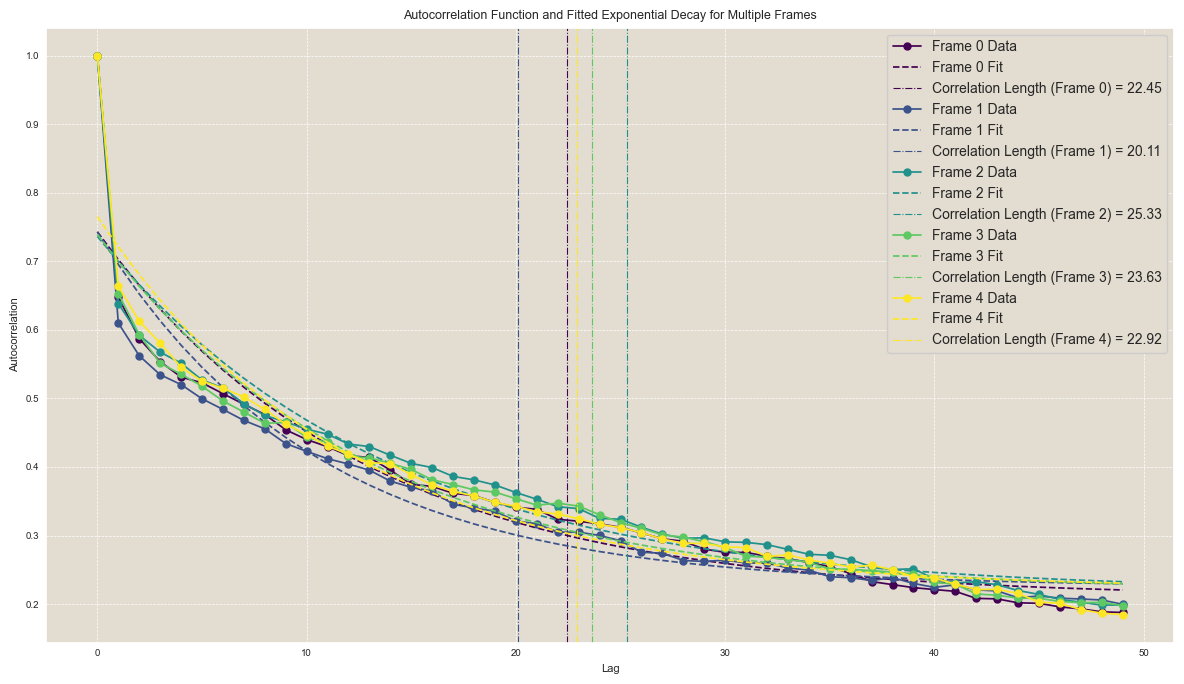

In [6]:
# Generate dynamic colors based on number of frames using a colormap
def generate_dynamic_colors(n):
    """
    Generate a list of distinct colors based on the number of frames using a colormap.
    
    Parameters:
    - n (int): Number of required colors.
    
    Returns:
    - list: List of RGBA colors.
    """
    colormap = plt.cm.viridis  # using the 'viridis' colormap, but this can be changed to any other colormap
    return [colormap(i) for i in np.linspace(0, 1, n)]

def plot_autocorrelation_values_multiple_frames(df):
    """
    Plots the autocorrelation values and the fitted exponential decay for multiple frames.
    
    Parameters:
    - df (DataFrame): DataFrame containing 'Correlation Length', 'results', and 'fitted_values' columns.
    
    Returns:
    - None: Displays the plot.
    """
    
    plt.figure(figsize=(12, 7))
    
    # Get dynamic colors based on the number of frames
    colors = generate_dynamic_colors(len(df))
    
    for idx, row in df.iterrows():
        lambda_tau = row['Correlation Length']
        results = row['results']
        fitted_values = row['fitted_values']
        
        # Plot autocorrelation values and fitted exponential decay
        plt.plot(results, marker='o', linestyle='-', markersize=5, color=colors[idx], label=f'Frame {idx} Data')
        plt.plot(fitted_values, linestyle='--', color=colors[idx], label=f'Frame {idx} Fit')
        plt.axvline(x=lambda_tau, color=colors[idx], linestyle='-.', linewidth=0.8, label=f'Correlation Length (Frame {idx}) = {lambda_tau:.2f}')
    
    # Adding labels, title, and legend
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function and Fitted Exponential Decay for Multiple Frames')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Test the function using the df DataFrame
plot_autocorrelation_values_multiple_frames(df.iloc[:5,:])


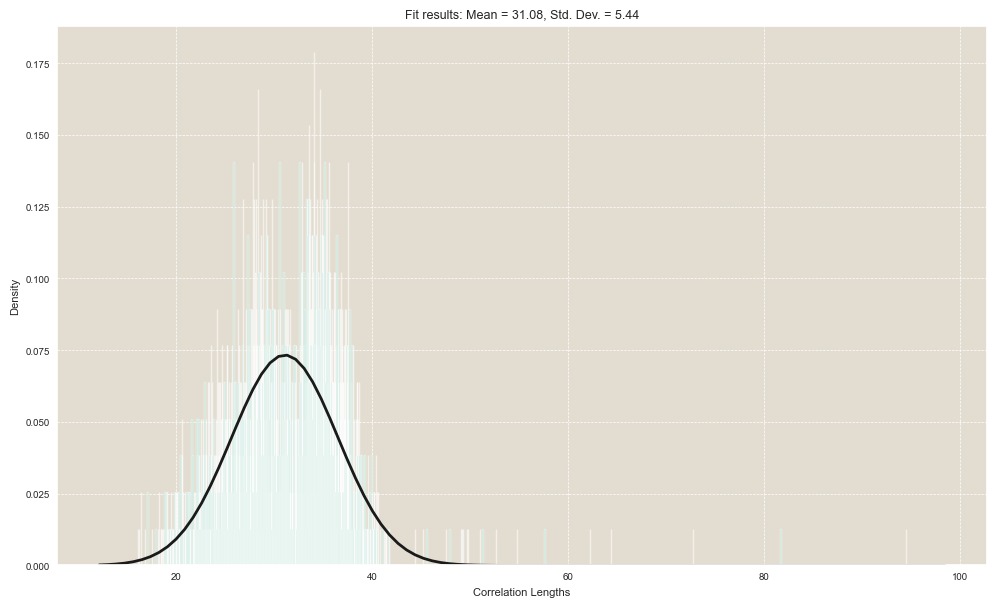

In [7]:
def plot_histogram(dataframe):
    """
    Plots a histogram of correlation lengths and fits the data to a normal distribution.
    
    Parameters:
    - dataframe (DataFrame): Dataframe with the necessary data.
    
    Returns:
    - mu (float): Mean of the fitted normal distribution.
    - std (float): Standard deviation of the fitted normal distribution.
    """
    # Extract the correlation lengths and clean any non-finite values
    cl_values = dataframe['Correlation Length'].dropna().values
    cl_values = cl_values[np.isfinite(cl_values)]
    
    plt.figure(figsize=(12, 7))
    n, bins, patches = plt.hist(cl_values, bins=len(dataframe['time [min]'].unique()), density=True, alpha=0.6, color='g')
    
    # Fit a normal distribution to the data
    mu, std = norm.fit(cl_values)
    
    # Plot the fitted distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(f"Fit results: Mean = {mu:.2f}, Std. Dev. = {std:.2f}")
    plt.xlabel('Correlation Lengths')
    plt.ylabel('Density')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
    return mu, std

# Test the cleaned function
mean_cleaned, std_dev_cleaned = plot_histogram(df)


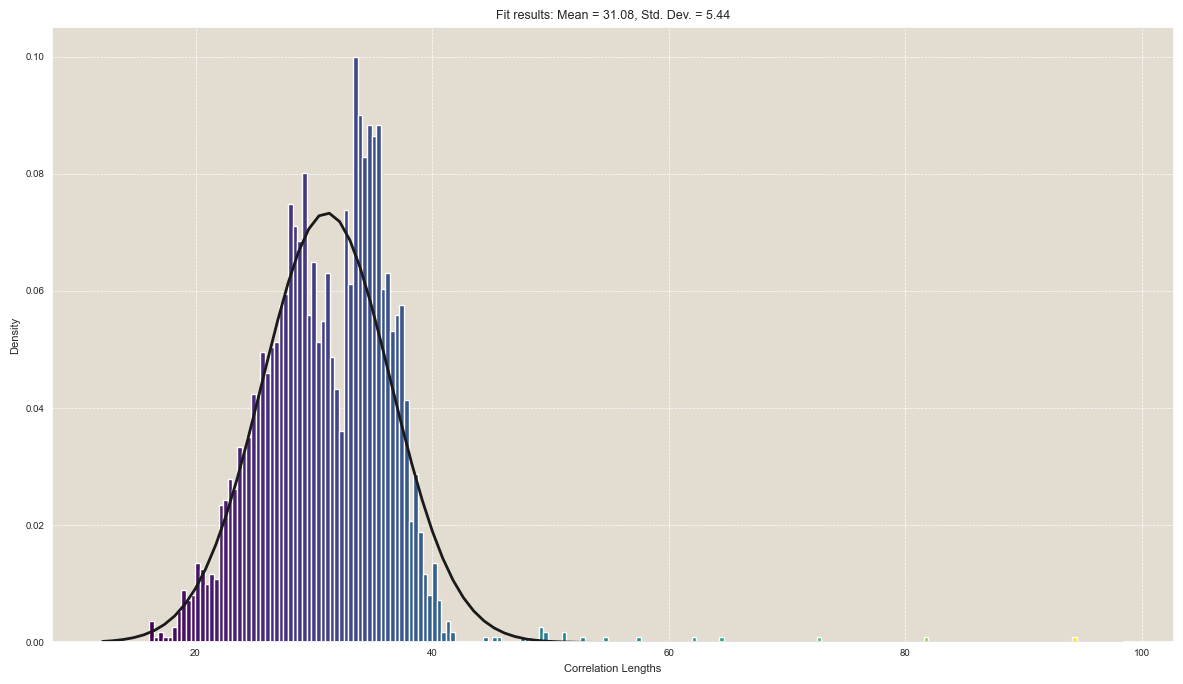

In [8]:
def plot_histogram(dataframe, bins=None):
    """
    Manually plots a histogram of correlation lengths in viridis colors 
    and fits the data to a normal distribution with a black line.
    
    Parameters:
    - dataframe (DataFrame): Dataframe with the necessary data.
    - bins (int, optional): Number of bins for the histogram. If None, will use the number of unique values.
    
    Returns:
    - mu (float): Mean of the fitted normal distribution.
    - std (float): Standard deviation of the fitted normal distribution.
    """
    # Extract the correlation lengths and clean any non-finite values
    cl_values = dataframe['Correlation Length'].dropna().values
    cl_values = cl_values[np.isfinite(cl_values)]
    
    # Set default bins to the number of unique values if not provided
    if bins is None:
        bins = len(np.unique(cl_values))
    
    # Compute the histogram manually
    counts, bin_edges = np.histogram(cl_values, bins=bins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(12, 7))
    
    # Get colormap colors
    colormap = plt.cm.viridis
    colors = colormap(np.linspace(0, 1, len(counts)))
    
    # Plot histogram bars manually with viridis colors
    for center, count, color in zip(bin_centers, counts, colors):
        plt.bar(center, count, width=bin_width, align='center', color=color)
    
    # Fit a normal distribution to the data
    mu, std = norm.fit(cl_values)
    
    # Plot the fitted distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k-', linewidth=2)
    plt.title(f"Fit results: Mean = {mu:.2f}, Std. Dev. = {std:.2f}")
    plt.xlabel('Correlation Lengths')
    plt.ylabel('Density')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    return mu, std

# Test the function
mean, std_dev = plot_histogram(df, bins=200)


In [9]:
import ipywidgets as widgets
from IPython.display import display

def plot_with_widgets(dataframe):
    # Extract the correlation lengths and clean any non-finite values
    cl_values = dataframe['Correlation Length'].dropna().values
    cl_values = cl_values[np.isfinite(cl_values)]
    max_bins = len(cl_values)

    @widgets.interact(bins=widgets.IntSlider(min=1, max=max_bins, step=1, value=max_bins, description='Bins:'))
    def interactive_plot(bins):
        plt.figure(figsize=(12, 7))

        # Compute the histogram manually
        counts, bin_edges = np.histogram(cl_values, bins=bins, density=True)
        bin_width = bin_edges[1] - bin_edges[0]
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Get colormap colors
        colormap = plt.cm.viridis
        colors = colormap(np.linspace(0, 1, len(counts)))

        # Plot histogram bars manually with viridis colors
        for center, count, color in zip(bin_centers, counts, colors):
            plt.bar(center, count, width=bin_width, align='center', color=color)

        # Fit a normal distribution to the data
        mu, std = norm.fit(cl_values)

        # Plot the fitted distribution
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k-', linewidth=2)
        
        # Vertical dashed line for the mean
        plt.axvline(mu, color='red', linestyle='dashed', linewidth=1.5)
        
        # Title and labels
        plt.title(f"Fit results: Mean = {mu:.2f}, Std. Dev. = {std:.2f}")
        plt.xlabel('Correlation Lengths')
        plt.ylabel('Density')
        
        # Enhance x-axis ticks for more clarity
        plt.xticks(np.linspace(xmin, xmax, min(20, bins)))
        
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()


# Remove outliers. Comment to see raw data
df.loc[df['Correlation Length'] > 45, 'Correlation Length'] = 31
plot_with_widgets(df)


interactive(children=(IntSlider(value=2831, description='Bins:', max=2831, min=1), Output()), _dom_classes=('w…

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


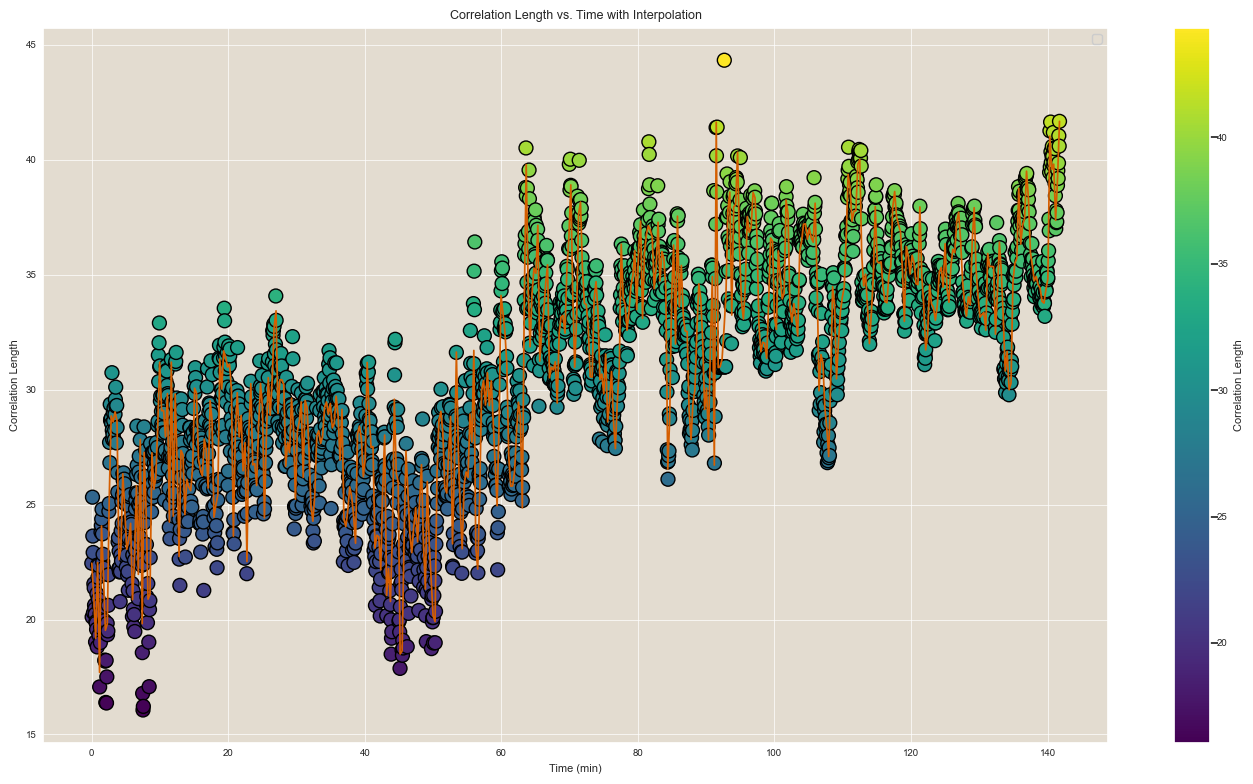

In [10]:
def plot_autocorrelation_length_vs_time_filtered(df):
    """
    Plots the correlation length against time with interpolation, filtering out non-finite values.
    
    Parameters:
    - df (DataFrame): DataFrame containing 'time [min]' and 'Correlation Length' columns.
    
    Returns:
    - None: Displays the plot.
    """
    
    plt.figure(figsize=(14, 8))
    
    # Filter out non-finite values
    df_filtered = df[df['Correlation Length'].notna() & np.isfinite(df['Correlation Length'])]
    
    # Use scatter for heatmap coloring
    plt.scatter(df_filtered['time [min]'], df_filtered['Correlation Length'], 
                c=df_filtered['Correlation Length'], cmap='viridis', s=100, edgecolor='black')
    
    # Interpolate using cubic spline
    cs = CubicSpline(df_filtered['time [min]'], df_filtered['Correlation Length'])
    times = np.linspace(df_filtered['time [min]'].min(), df_filtered['time [min]'].max(), 500)
    plt.plot(times, cs(times), 'r-')
    
    # Add labels, title, and colorbar
    plt.colorbar(label='Correlation Length')
    plt.xlabel('Time (min)')
    plt.ylabel('Correlation Length')
    plt.title('Correlation Length vs. Time with Interpolation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Remove outliers. Comment to see raw data
df.loc[df['Correlation Length'] > 45, 'Correlation Length'] = 31
# Test the function using the df DataFrame
plot_autocorrelation_length_vs_time_filtered(df)


In [11]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar
from bokeh.layouts import column
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from scipy.interpolate import CubicSpline

def plot_correlation_length_vs_time(df_correlation_length):
    """
    Plot correlation length against time using provided DataFrame with Bokeh, color the y-values with a heatmap in viridis,
    and connect the points with an interpolated line. Tooltips display the correlation length on hover.
    
    Parameters:
    - df_correlation_length (DataFrame): DataFrame with columns for time (in minutes) and correlation length.
    
    Returns:
    - None: Displays the interactive plot.
    """
    
    df_correlation_length['Correlation Length'] = df_correlation_length['Correlation Length'] * (11.75/2)

    # Interpolate using cubic spline
    cs = CubicSpline(df_correlation_length['time [min]'], df_correlation_length['Correlation Length'])
    times = np.linspace(df_correlation_length['time [min]'].min(), df_correlation_length['time [min]'].max(), 500)
    
    # Set up the Bokeh plot
    p = figure(width=800, height=400, title='Correlation Length vs. Time with Interpolation',
               x_axis_label='time [min]', y_axis_label='Correlation Length', tools='')
    
    # Add the data points with hover info
    mapper = linear_cmap(field_name='Correlation Length', palette=Viridis256, 
                         low=min(df_correlation_length['Correlation Length']), 
                         high=max(df_correlation_length['Correlation Length']))
    
    source = ColumnDataSource(df_correlation_length)
    p.scatter(x='time [min]', y='Correlation Length', source=source, size=10, color=mapper, alpha=1)  # Added alpha for transparency
    
    # Add the interpolated line (after scatter to ensure it's on top)
    p.line(times, cs(times), line_color='orange', line_width=2)
    
    # Add hover tool
    hover = HoverTool()
    hover.tooltips = [("Correlation Length", "@{Correlation Length}"), ("File Name", "@{file_name}")]
    p.add_tools(hover)
    
    # Color bar
    color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
    p.add_layout(color_bar, 'right')
    
    output_notebook()
    show(p)

# Remove outliers. Comment to see raw data
df.loc[df['Correlation Length'] > 45, 'Correlation Length'] = 31
# Test the modified function with the df_correlation_length DataFrame
df["Correlation Length"] = df["Correlation Length"].fillna(30)
plot_correlation_length_vs_time(df.iloc[:,:3])



Loading BokehJS ...

In [ ]:
sorted_df = df.sort_values(by=['Correlation Length'], ascending=True)
sorted_df.head(20)

### What is Spatial Frequency?

Spatial frequency refers to the rate of change of some quantity (like intensity, brightness, or in this case, velocity magnitude) over space. In images, high spatial frequencies correspond to rapid changes in brightness, such as the edges of objects or fine details. In contrast, low spatial frequencies correspond to slow changes in brightness, like smooth gradients or broad features.

For a vector field:

- **High Spatial Frequencies**: These correspond to areas where the magnitude of the vectors (or the direction of the vectors) changes rapidly over short distances. Think of it as "fine structures" in the flow, where things are happening on a small scale.
  
- **Low Spatial Frequencies**: These represent regions where the magnitude of the vectors changes slowly over large distances. It's like the "broad strokes" of the flow, capturing the large-scale motion.

### How does it relate to Correlation Length?

The correlation length is a measure of the size over which some property (like velocity magnitude) is correlated. It gives an idea of the "typical size" of structures or patterns in the data.

Spatial frequency and correlation length are inversely related:

- **High Spatial Frequency**: Small-scale structures. These structures would have a short correlation length since the property (like velocity magnitude) would only be correlated over short distances.
  
- **Low Spatial Frequency**: Large-scale structures. These would have a long correlation length, as the property might be correlated over vast distances.

### Are Frequencies Related to the Correlation Length?

Yes, they are related. If you find that your data has dominant high spatial frequencies, it means there are many small-scale structures in your flow. This would correspond to a short correlation length. Conversely, dominant low spatial frequencies indicate that the flow has large-scale structures, corresponding to a long correlation length.

In essence, the correlation length gives you a characteristic size of the structures in your flow, and the spatial frequencies tell you about the scales of structures that are present. If the correlation length is short, it implies that the dominant structures in your flow are small, and you'll see dominant high spatial frequencies. If the correlation length is long, the dominant structures are large, and you'll see dominant low spatial frequencies.


## Fourier Transform: A Brief Overview

The **Fourier Transform** is a powerful mathematical tool that breaks down a function (or signal) into its constituent sinusoidal components. Think of it as identifying the musical notes that make up a complex sound. 

For a spatial signal, like the velocity magnitude in a fluid, these sinusoidal components represent variations in space, termed as "spatial frequencies". A high spatial frequency indicates rapid changes in the pattern over short distances, while a low spatial frequency means the pattern changes slowly over larger distances.

## Mathematical Definition

The continuous Fourier Transform of a function \( f(t) \) is defined as:

$$
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i\omega t} \, dt
$$

Here:
- \( F(\omega) \) is the Fourier Transform of \( f(t) \).
- \( \omega \) is the angular frequency.
- \( e^{-i\omega t} \) is a complex exponential, which combines both cosine and sine functions due to Euler's formula.

For spatial data, like the velocity magnitude, the function is a function of space, say \( v(x, y) \), and the Fourier Transform becomes two-dimensional:

$$
V(k_x, k_y) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} v(x, y) e^{-i(k_x x + k_y y)} \, dx \, dy
$$

Here:
- \( V(k_x, k_y) \) is the Fourier Transform in 2D.
- \( k_x \) and \( k_y \) are spatial frequencies in the x and y directions, respectively.

## The Complex Nature

You might have noticed the use of the imaginary unit \( i \) in the formulas above. This gives the Fourier Transform its complex nature. But why complex?

When you apply the Fourier Transform, you're essentially projecting your data onto sinusoids. These sinusoids can be represented compactly using complex exponentials due to Euler's formula:

$$
e^{ix} = \cos(x) + i\sin(x)
$$

The result of the Fourier Transform, thus, has both magnitude and phase. The magnitude tells you how strong each frequency component is in your data, while the phase tells you about the alignment or shift of the sinusoids with respect to the original data.

## Relevance to Velocity Magnitudes

In the context of your velocity magnitude data, taking its Fourier Transform allows you to identify patterns or structures of different sizes. If certain spatial frequencies dominate the result, it indicates the presence of structures of corresponding sizes in the fluid flow.

For instance, if the Fourier Transform has a strong component at a particular \( k_x \), it means there's a repeating structure in the fluid flow with a size related to that spatial frequency.

In conclusion, the Fourier Transform, with its real and complex components, provides a complete spectrum of the different spatial frequencies present in your data. It's a window into the underlying patterns and structures in the velocity magnitude, revealing details that might be hard to discern in the spatial domain.